# Skin Cancer Recognition 

From Authors

Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [1]:
import numpy as np
import pandas as pd
import os 
import torch.utils.data as data
import keras
import random 
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D

# from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense

from keras.preprocessing import image
from numpy import array
from keras import metrics
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = os.path.join('', 'dataset')

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'


Using TensorFlow backend.


# Считаем данные 

In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [3]:
skin_data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes

In [4]:
skin_data.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                     path                       cell_type  \
0  dataset\images_part_1\ISIC_0027419.jpg  Benign keratosis-like lesions    
1  dataset\images_part_1\ISIC_0025030.jpg  Benign keratosis-like lesions    
2  dataset\images_part_1\ISIC_0026769.jpg  Benign keratosis-like lesions    
3  dataset\images_part_1\ISIC_0025661.jpg  Benign keratosis-like lesions    
4  dataset\images_part_2\ISIC_0031633.jpg  Benign keratosis-like lesions    

   cell_type_idx  
0              2  
1              2  
2              2  
3              2  
4              2

In [5]:
skin_data['cell_type'].unique()

array(['Benign keratosis-like lesions ', 'Melanocytic nevi',
       'Dermatofibroma', 'dermatofibroma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

# Визуализация данных 

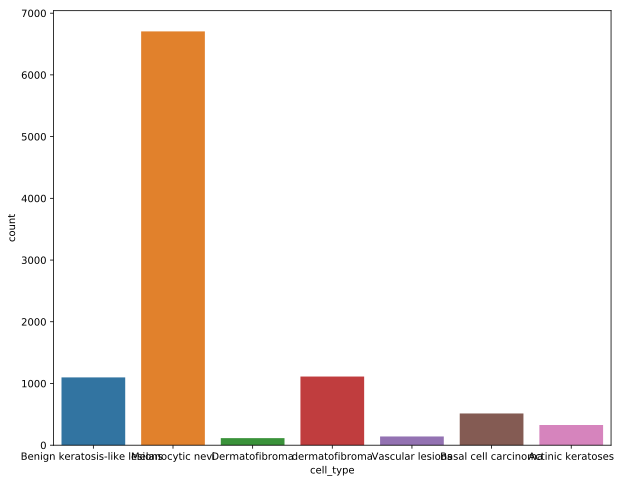

In [19]:
# make wrapping for cell_type names 
plt.figure(figsize=(10, 8))
sns.countplot(x='cell_type',data = skin_data)

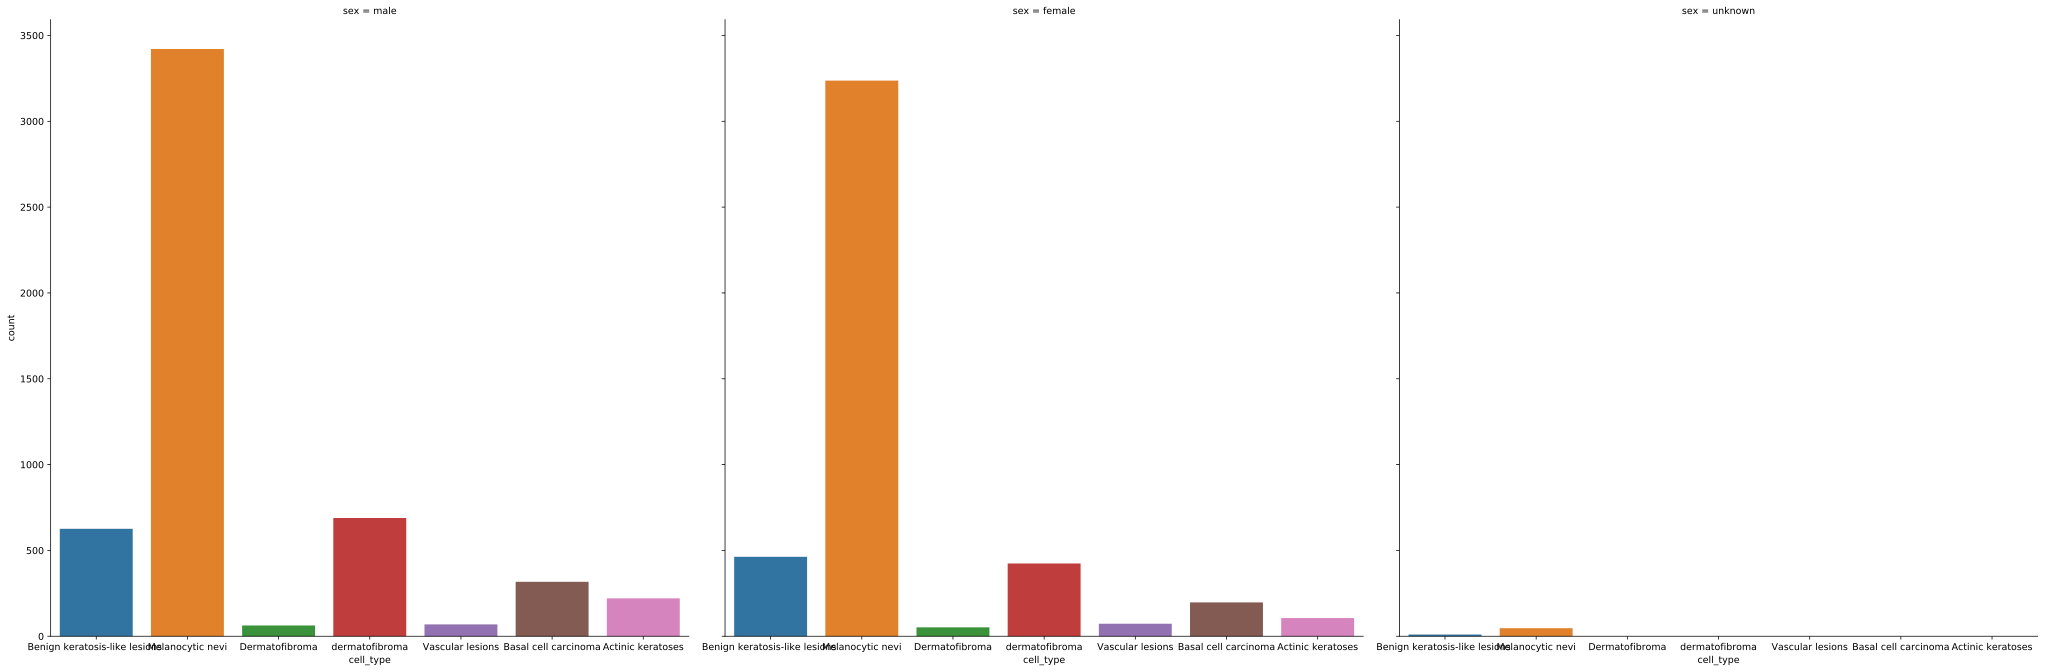

In [20]:
sns.catplot(x="cell_type" ,col="sex",
                data=skin_data, kind="count",
               height=10, aspect=1);

In [ ]:
sns.catplot(x="dx", y="age", kind="swarm",
            data=skin_data);

In [5]:
def getRandomNV(x):
    rnd = random.randint(0, 100)
    if x == 'nv' and rnd < 20:
        return '1'
    else:
        return '0'

skin_data['usable'] = skin_data['dx'].apply(lambda x: getRandomNV(x))
skin_data['usable'].value_counts()

In [7]:
cut_skin_data = skin_data[(skin_data['dx'] == 'bkl') |
                          ((skin_data['dx'] == 'nv') & (skin_data['usable'] == '1' )) | 
                          (skin_data['dx'] == 'mel')]
cut_skin_data['dx'].value_counts()

nv     1338
mel    1113
bkl    1099
Name: dx, dtype: int64

In [8]:
data = []
IMAGE_DIMS = (200, 150, 3)
def load_img_with_cv2(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    return image

for img_path in cut_skin_data['path']:
    data.append(load_img_with_cv2(img_path))

In [9]:
data = np.array(data, dtype='float') / 255.0
labels = np.array(cut_skin_data['dx'])
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [10]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [11]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [13]:
datagen.fit(X_train)

# Определим топологию нейронной сети 

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), input_shape=(200,150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(layers.Conv2D(64, (3, 3)))
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 148, 64)      1792      
_________________________________________________________________
activation_6 (Activation)    (None, 198, 148, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 72, 64)        36928     
_________________________________________________________________
activation_7 (Activation)    (None, 97, 72, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 34, 64)        36928     
__________

# Обучим нейронную сеть 



In [16]:
history = model.fit(X_train, y_train, epochs=60, batch_size=128)

Epoch 1/60
2824/2824 [==============================] - 28s 10ms/step - loss: 0.6011 - acc: 0.6843
Epoch 2/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.5366 - acc: 0.7299
Epoch 3/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.5024 - acc: 0.7528
Epoch 4/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.4842 - acc: 0.7658
Epoch 5/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.4857 - acc: 0.7650
Epoch 6/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.4908 - acc: 0.7578
Epoch 7/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.4732 - acc: 0.7714
Epoch 8/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.4505 - acc: 0.7803
Epoch 9/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.4370 - acc: 0.7900
Epoch 10/60
2824/2824 [==============================] - 10s 4ms/step - loss: 0.4309 - acc: 0.7893
Epoch 11/60
2824/2

# Построим графики результатов обучения нейронной сети 


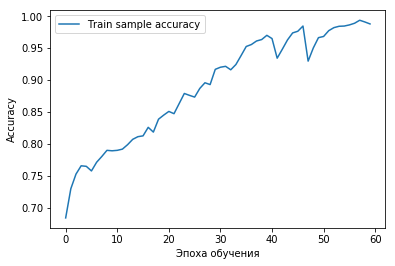

In [17]:
plt.plot(history.history['acc'], label='Train sample accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Функция для отрисовки промежуточных слоёв нейросети

# Проверим полученную модель на тестовой выборке 

In [18]:
score = model.evaluate(X_test, y_test, batch_size=64)
score

707/707 [==============================] - 5s 6ms/step


[1.1178179719660541, 0.7864215263551498]

# Выгрузим промежуточные изображения из слоёв нейронной сети 

# Сделать визуализацию весов слоёв нейронной сети 

Функция для отрисовки изображений

In [19]:
def print_map_features(activation):
    images_per_row = 8
    n_filters = activation.shape[-1]
    size = activation.shape[1]
    size2 = activation.shape[2]
    n_cols = n_filters // images_per_row
    display_grid = np.zeros((n_cols * size, images_per_row * size2))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size2 : (row + 1) * size2] = channel_image
        
    scale = 2.5 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [23]:
img_for_feature_draw = X_test[22]

# Первый слой 

In [24]:
first_activation_model = models.Model(inputs=model.input, outputs=model.layers[0].output)
first_layers_activation = first_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
first_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  (None, 200, 150, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 198, 148, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


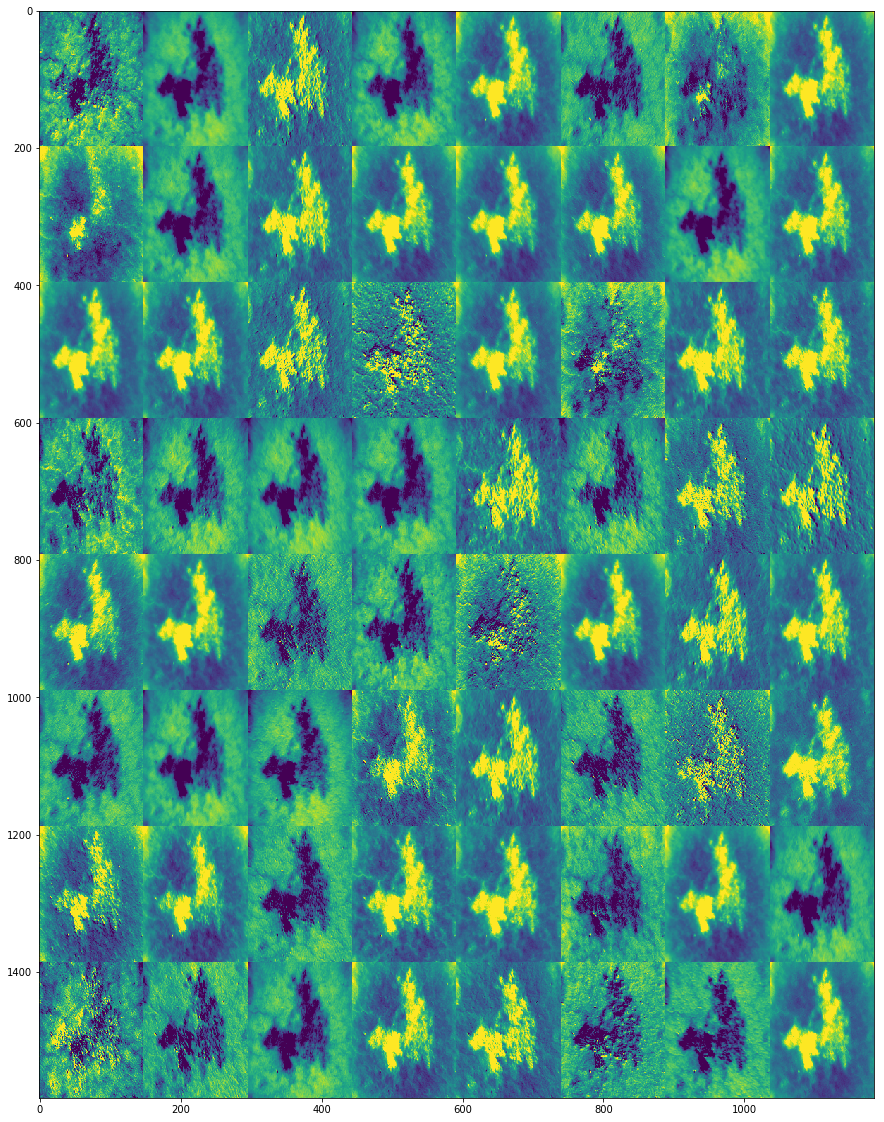

In [25]:
print_map_features(first_layers_activation)

# Второй слой 

In [26]:
second_activation_model = models.Model(inputs=model.input, outputs=model.layers[3].output)
second_layers_activation = second_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
second_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  (None, 200, 150, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 198, 148, 64)      1792      
_________________________________________________________________
activation_6 (Activation)    (None, 198, 148, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 72, 64)        36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


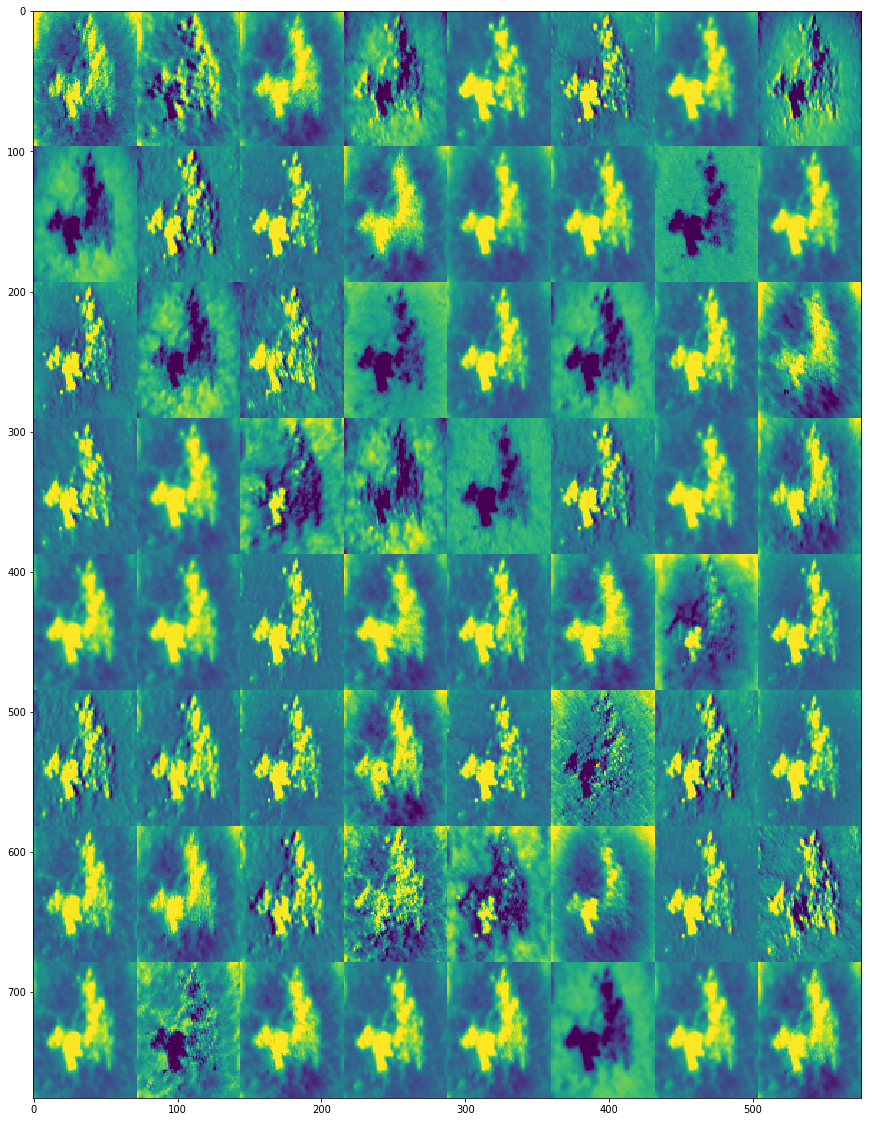

In [27]:
print_map_features(second_layers_activation)

# Третий слой

In [28]:
third_activation_model = models.Model(inputs=model.input, outputs=model.layers[6].output)
third_layers_activation = third_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
third_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  (None, 200, 150, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 198, 148, 64)      1792      
_________________________________________________________________
activation_6 (Activation)    (None, 198, 148, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 72, 64)        36928     
_________________________________________________________________
activation_7 (Activation)    (None, 97, 72, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 36, 64)        0         
__________

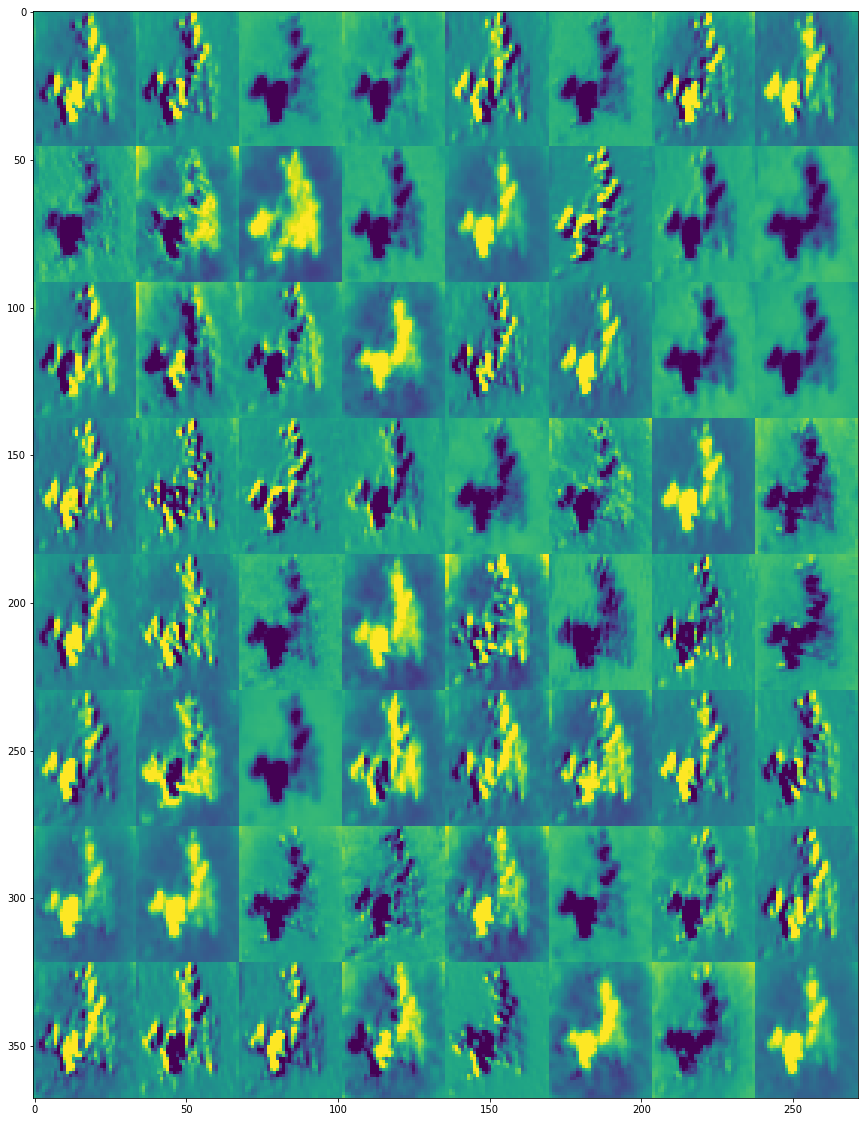

In [29]:
print_map_features(third_layers_activation)

# Четвертый слой 

In [37]:
Frth_activation_model = models.Model(inputs=model.input, outputs=model.layers[9].output)
Frth_layers_activation = Frth_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
Frth_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 200, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 148, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 148, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 72, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 97, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 36, 32)        0         
__________

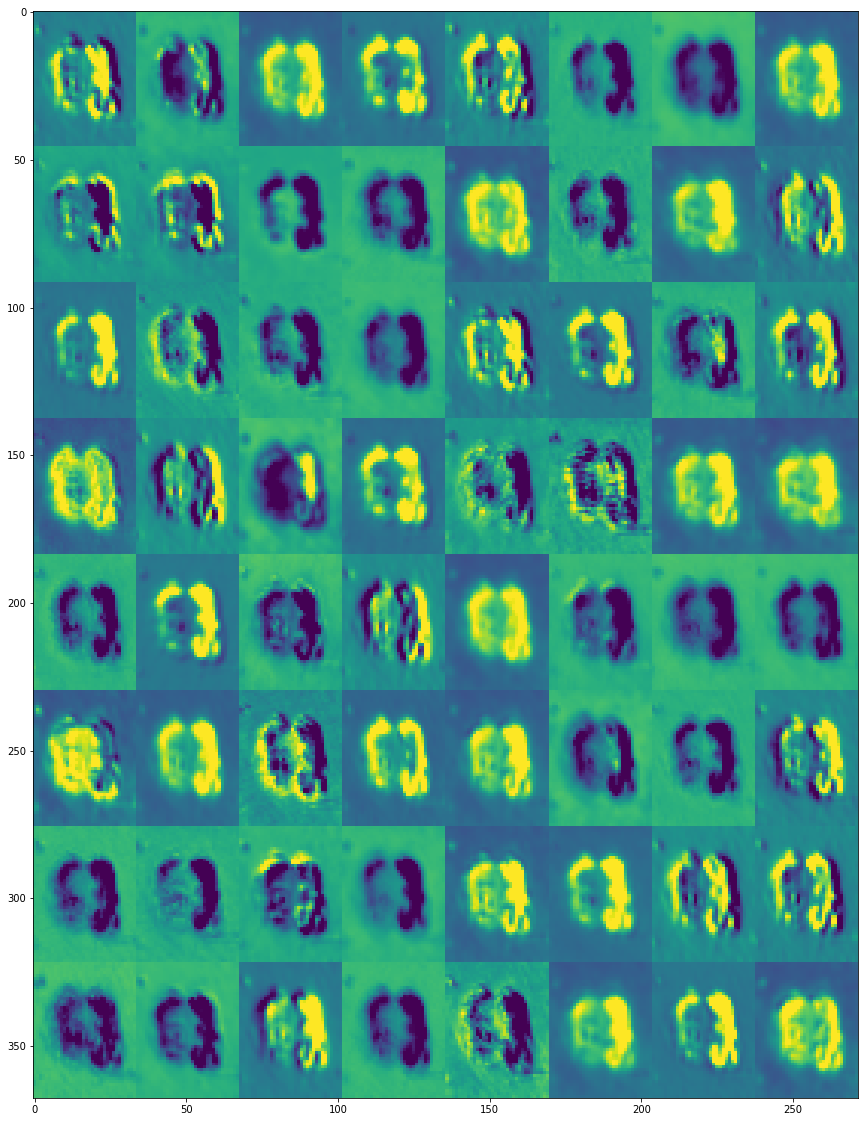

In [38]:
print_map_features(third_layers_activation)